### Extract and clean time series data

First, we need to get and clean some financial data. Create a function `
def fetch_log_returns(start: str,end: str, tickers: str = '^GSPC ^FTSE ^N225 ^GDAXI ^IBEX') -> pd.DataFrame:` in utils.py that pulls daily pricing data from Yahoo finance and returns a pandas DataFrame with the daily log returns of every asset. 
- Use `yfinance.download()` to get the data from the already defined stock indeces
- See **logarithmic returns** definition in  (1)

In [1]:
from utils import fetch_log_returns
training_dataset = fetch_log_returns(start = '1995-01-01', end ='1995-12-31')

[*********************100%***********************]  5 of 5 completed


In [2]:
training_dataset.head()

,sp500,dax,ftse,nikkei,ibex
Date,,,,,
1995-01-05 00:00:00+00:00,-0.000803,-0.010397,-0.006345,-0.003457,-0.019565
1995-01-06 00:00:00+00:00,0.000738,0.003280,0.010726,-0.004939,0.000000
1995-01-09 00:00:00+00:00,0.000326,-0.002330,-0.003006,-0.003826,-0.014346
1995-01-10 00:00:00+00:00,0.001843,0.004213,0.001504,0.002903,-0.005274
1995-01-11 00:00:00+00:00,-0.000043,-0.000155,-0.003601,0.002408,-0.010125


### Define the problem instance and model parameters

Must of the functions you will be asked to build depend on those values, so it is important to understand its meaning. 

In [3]:
from model_params import LAMBDA_1, LAMBDA_2, LAMBDA_3, NLAYERS, NSHOTS, NUM_ASSETS, SIGMA_TARGET, TWO_QUBIT_GATES, K, N, RISK_FREE_RATE

### Build the circuit Ansatz (without angle embedding)

The ansatz is to Variational Quantum Algorithms what the neural network in Deep Learning. It is the mathematical structure that is supposed to adapt its structure according to the data is being fed with. We propose the most standard ansatz, the Hardware Efficient. See Section V. 

Build a function `build_hardware_efficient_ansatz(num_qubits: int = N, num_layers: int = NLAYERS, two_gate: str = "CNOT") -> models.Circuit`that returns a Qibo circuit with the same structure as in FIG 2. 

In [17]:
from ansatz import build_hardware_efficient_ansatz
ansatz = build_hardware_efficient_ansatz()
print('Hardware efficient circuit ansatz')
print()
print(ansatz.draw())


Hardware efficient circuit ansatz

q0: ─U2─U2─o───────U1─M─
q1: ─U2─U2─X─o─────U1─M─
q2: ─U2─U2───X─o───U1─M─
q3: ─U2─U2─────X─o─U1─M─
q4: ─U2─U2───────X─U1─M─


### Build the Portfolio Optimization Hamiltonian and run the optimization process


In [5]:
import numpy as np
from qibo.optimizers import optimize
from cost_function import compute_total_energy
from ansatz import build_hardware_efficient_ansatz, compute_number_of_params_hwea


# Optimize starting from a random guess for the variational parameters
initial_params = np.random.uniform(0, 2*np.pi, compute_number_of_params_hwea(N,NLAYERS))

circuit = build_hardware_efficient_ansatz()
# perform optimization
best, optimal_params, extra = optimize(compute_total_energy, initial_params, args=(circuit, training_dataset))

# set final solution to circuit instance
print('Ground state energy:', best)
print()
print('Optimal parameters', optimal_params)
print()
print('Optimization process info', extra)

[Qibo 0.2.8|INFO|2024-10-04 09:01:53]: Using numpy backend on /CPU:0


Energy: 150.2276139847143
Energy: 143.2160048776063
Energy: 149.50716135466575
Energy: 187.2402232175329
Energy: 155.5811104437738
Energy: 144.90315095501583
Energy: 144.29377371791963
Energy: 146.6673956357382
Energy: 145.96490752558813
Energy: 148.16610224305262
Energy: 143.76212985983136
Energy: 149.41664751767848
Energy: 147.5733720074696
Energy: 145.74448915520935
Energy: 148.55498999910304
Energy: 145.41910783428617
Energy: 143.8241538330297
Energy: 148.16627167751903
Energy: 142.7620677519422
Energy: 144.4812989547986
Energy: 143.49644192809467
Energy: 143.24767319523568
Energy: 147.24432140625345
Energy: 139.49869171173896
Energy: 144.3082396340119
Energy: 148.4937087852932
Energy: 146.2308694253281
Energy: 142.79486564379042
Energy: 144.5434513912634
Energy: 142.91897246470964
Energy: 152.41367831358258
Energy: 148.22841694696731
Energy: 145.21416483132322
Energy: 144.24545679582295
Energy: 146.4802198850711
Energy: 145.1209054541784
Energy: 143.9188219080637
Energy: 143.46520

### Results parsing


In [6]:
from results_parsing import get_optimal_binary_portfolios_prob_and_energy

optimized_ansatz = ansatz.set_parameters(optimal_params)
optimal_binary_portfolios = get_optimal_binary_portfolios_prob_and_energy(ansatz, training_dataset)
optimal_binary_portfolios


{'11111': {'stat_freq': 0.89, 'energy': 100.0625}}

In [7]:
from results_parsing import get_binary_portfolio, get_minimum_energy, get_decimal_portfolio

min_energy = get_minimum_energy(optimal_binary_portfolios)
min_energy_portfolio = ''
for portfolio, data in optimal_binary_portfolios.items(): 
    if data['energy'] == min_energy: 
        min_energy_portfolio = portfolio
print('Minimum energy portfolio:',min_energy_portfolio)


Minimum energy portfolio: 11111


In [8]:
binary_porfolio = get_binary_portfolio(training_dataset.columns, min_energy_portfolio)
binary_porfolio

{'sp500': '1', 'dax': '1', 'ftse': '1', 'nikkei': '1', 'ibex': '1'}

In [9]:

portfolio = get_decimal_portfolio(binary_porfolio)
portfolio

{'sp500': 0.25, 'dax': 0.25, 'ftse': 0.25, 'nikkei': 0.25, 'ibex': 0.25}

In [12]:
from utils import granularity
granularity()

ImportError: cannot import name 'granularity' from 'utils' (/home/adria/Projects/haqtoberfest2024/challenges/quantum_finance/solved/utils.py)

### Calculating portfolio metrics

In [13]:
from results_parsing import get_portfolio_metrics
get_portfolio_metrics(portfolio, training_dataset)

{'Returns': 0.1435316776677248,
 'Volatility': 0.0888969875046529,
 'Sharpe Ratio': 1.2771150165440928,
 'Normalized Weights': array([0.2, 0.2, 0.2, 0.2, 0.2])}

Matplotlib is building the font cache; this may take a moment.


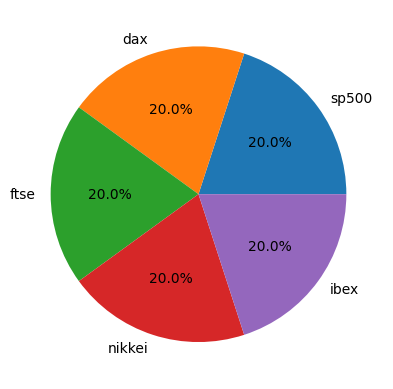

In [16]:
import matplotlib.pyplot as plt
sizes = portfolio.values()
fig, ax = plt.subplots()
ax.pie(sizes, labels=list(portfolio.keys()), autopct='%1.1f%%')
plt.show()

A explicar en el README: 

Como encarar el challenge? 
1. explicar la situacion de que llego tarde
2. read the paper in diagonal until section V. Todo eso ya está resuelto. Consultarlo encase de duda. que es lo importante? entender como mapear el problema, por eso doy el codigo, intentad avanzar rápido. 
3. Al estar modularizado, podéis trabajar en paralelo en el desarollo de funciones. Teneis un docstring detallado y los tipos de lo que se espera a la entrada y la salida. 

Parte fácil NO guiada: 
- Resolver por fuerza bruta para ver lo mala que es la optimización pero lo precisa que es la formulación
- Como compara la solución de tu algortimo con los datos históricos? Benchnarking
- MonteCarlo for PO

Para hacer por libre si sabes mucho: 

- Trainable -> unsupervised quantum machine learning